In [75]:
%matplotlib inline

In [48]:
import pandas as pd
import subprocess
import re
import numpy as np

In [67]:
def get_rchnisan(year):
    hebcal_str = subprocess.run('../hebcal-master/./hebcal ' + str(year), shell=True, stdout=subprocess.PIPE, encoding='utf8').stdout
    date = re.search(r'([0-9]{1,2}/[0-9]{1,2}/[0-9]{4}) Erev Rosh Hashana', hebcal_str).group(1)
    return str(pd.to_datetime(date))[5:10]

In [68]:
get_dates_v = np.frompyfunc(get_rchnisan, 1, 1)

In [93]:
def is_hebrew_leap(y):
    leap ='Adar II' in subprocess.run('../hebcal-master/./hebcal ' + str(y), shell=True, stdout=subprocess.PIPE, encoding='utf8').stdout
    return leap

In [94]:
is_hebrew_leap_v = np.frompyfunc(is_hebrew_leap, 1, 1)

In [132]:
pd.Timestamp.min, pd.Timestamp.max

(Timestamp('1677-09-21 00:12:43.145225'),
 Timestamp('2262-04-11 23:47:16.854775807'))

In [107]:
df = pd.DataFrame(index=pd.RangeIndex(1700, 2200, name='year'))

In [108]:
df['hebrew_leap'] = is_hebrew_leap_v(df.index)

In [109]:
df['rosh_hashana'] = get_dates_v(df.index)

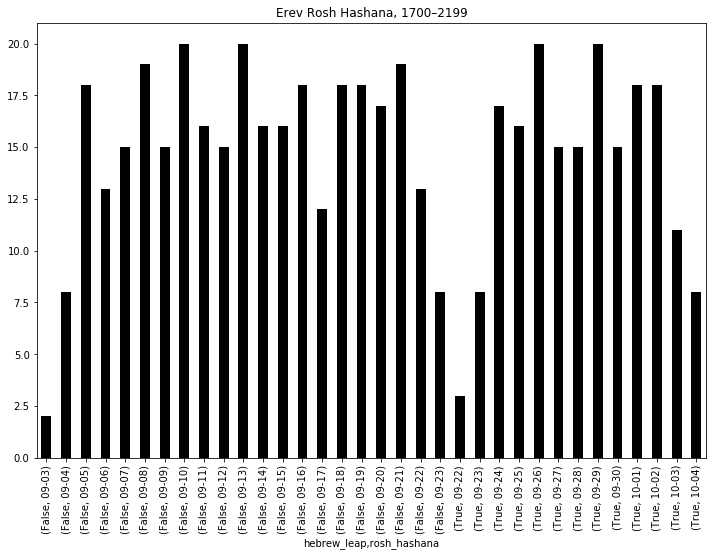

In [133]:
df.groupby(['hebrew_leap', 'rosh_hashana']).size().plot.bar(color='k', figsize=(12,8), title='Erev Rosh Hashana, 1700–2199')

In [126]:
grouped = pd.DataFrame(df.groupby(['hebrew_leap', 'rosh_hashana']).size())

AttributeError: Unknown property level

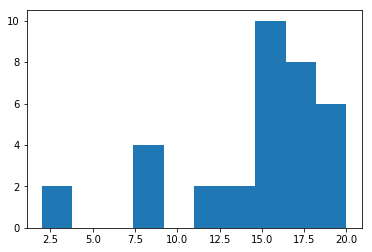

In [131]:
grouped.plot.hist(level=['hebrew_leap'])